### **Import/install necessary libraries**

- pip install matplotlib-label-lines
- pip install SciencePlots

In [1]:
import numpy as np
import pandas as pd
import sys
import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap, hsv_to_rgb
from labellines import labelLine, labelLines
import scienceplots
import functools
from functools import partial
import seaborn as sns
import scipy
from scipy.optimize import curve_fit
import warnings
warnings.simplefilter("ignore", RuntimeWarning)
plt.style.use(["science", "notebook", "grid"])


## **Define functions used in the model**

### **Fitness functions**

In [2]:
def fitness_func_scaled(filename, sheet, n, k):
    """
    reads data for relative growth vs substrate concentration, returns their scaled versions
    n, k = Hill coefficient, IC50 (μM) values respectively
    """
    
    data = pd.read_excel(filename, sheet_name=sheet)
    conc = data["Concentration"] # in μM
    rel_growth = data["Relative_Growth"] # normalized to the range [0,1]
    
    """
    scaling the x-axis:
    substrate concentration is considered as the equivalent to total activity
    in our model, total activity overall ranges from 0 to 2 (for r values of 1 to -1), with arbitrary units
    hence, raw substrate concentration is scaled such that the max value is 2.00 (arb. units)
    """
    
    conc_max = conc.max() 
    conc_new = conc * (2 / conc_max) 
    k_new = k * (2 / conc_max) # since the IC50 value is also a substrate conc., it is scaled similarly
    
    """
    scaling the y-axis:
    similar to the scaling factor for the Hill function, such that data passes through (1,1)
    """
    
    rel_growth_new = rel_growth * (1 + k_new**n)
    
    return conc, rel_growth, conc_new, rel_growth_new, n, k_new
    
# run the function to get scaled n,k values for our fitness functions
_, _, _, _, n1, k1 = fitness_func_scaled("../Data/Data_Despres2022.xls", "Cytosine", n=6.10, k=71.0)
_, _, _, _, n2, k2 = fitness_func_scaled("../Data/Data_Despres2022.xls", "5FC", n=-0.80, k=9.14)

In [3]:
def Hill_fitness(activity, n, k):

    """Calculates fitness based on a Hill function"""

    if activity < 0:
        raise ValueError("Activity must be a positive value.")
        
    elif activity == 0:
        return 1 + k**n if n < 0 else 0

    return (1 + k**n) / (1 + (k / activity)**n)

# fitness increases with increasing activity, then plateus
fitness_1 = partial(Hill_fitness, n=n1, k=k1)

# fitness decreases with increasing activity, then plateus
fitness_2 = partial(Hill_fitness, n=n2, k=k2)


### **Helper functionss**

In [4]:
def init_results(geno, r_vals=None, g_vals=None, cAB_vals=None, sweep_vals=None):
    
    """
    initializes arrays to which the computed metrics for the given system are added
    """
    
    metrics = ["act", "fit1", "fit2"] # activity and fitness (with the two fitness functions), common to all genotypes
    
    if geno == "WT": # WT homozygous, monomer and dimer
        results = {
            "mono": {metric: 0 for metric in metrics},
            "di": {metric: 0 for metric in metrics}
        }

    elif geno == "Mut_homo": # mutant homozygous, monomer and dimer
        metrics.extend(["s1", "s2"])
        results = {
            "mono": {metric: np.zeros(len(r_vals)) for metric in metrics},
            "di": {metric: np.zeros(len(r_vals)) for metric in metrics}
        }
        
    elif geno == "Het" or geno == "Het_spec":  
        metrics.extend(["h1", "h2"])
        
        if geno == "Het": # heterozygous, monomer and dimer
            results = {
                "mono": {metric: np.zeros((len(g_vals), len(r_vals))) for metric in metrics},
                "di": {metric: np.zeros((len(g_vals), len(r_vals))) for metric in metrics},
                "rel": {metric: np.zeros((len(g_vals), len(r_vals))) for metric in metrics}
            }
            
        elif geno == "Het_spec": # heterospecificity
            results = {
                metric: np.zeros((len(cAB_vals), len(sweep_vals))) for metric in metrics
            }
            
    return metrics, results


In [5]:
def compute_metrics(results, geno=None, system=None, idx=None, 
                    activity=None, act_m=None, act_d=None, 
                    fit1=fitness_1, fit2=fitness_2, 
                    s1=None, s2=None, fixed_param=None):
    
    """
    function for computing the metrics - activity, fitness, s, h, Δ(activity), Δ(fitness), Δh depending on the system
    """

    if geno == "WT": # WT homozygous, monomer and dimer
        results[system]["act"] = activity
        results[system]["fit1"] = fit1(activity)
        results[system]["fit2"] = fit2(activity)
        
    elif geno == "Mut_homo": # mutant homozygous, monomer and dimer
        i = idx
        results[system]["act"][i] = activity
        results[system]["fit1"][i] = fit1(activity)
        results[system]["fit2"][i] = fit2(activity)
        results[system]["s1"][i] = 1 - results[system]["fit1"][i]
        results[system]["s2"][i] = 1 - results[system]["fit2"][i]
        
    elif geno == "Het": # heterozygous, monomer and dimer
        i,j = idx
        results[system]["act"][i,j] = activity
        results[system]["fit1"][i,j] = fit1(activity)
        results[system]["fit2"][i,j] = fit2(activity)
        results[system]["h1"][i,j] = (1 - results[system]["fit1"][i,j]) / s1[j]
        results[system]["h2"][i,j] = (1 - results[system]["fit2"][i,j]) / s2[j]
        
    elif geno == "Rel": # heterozygous, dimer - monomer
        i,j = idx
        results["rel"]["act"][i,j] = act_d - act_m
        results["rel"]["fit1"][i,j] = fit1(act_d) - fit1(act_m)
        results["rel"]["fit2"][i,j] = fit2(act_d) - fit2(act_m)
        results["rel"]["h1"][i,j] = (-results["rel"]["fit1"][i,j]) / s1[j]
        results["rel"]["h2"][i,j] = (-results["rel"]["fit2"][i,j]) / s2[j]
        
    elif geno == "Het_spec": # heterospecificity
        i,j,k = idx
        results["act"][i,j] = activity
        results["fit1"][i,j] = fit1(activity)
        results["fit2"][i,j] = fit2(activity)
        if fixed_param == "r":
            results["h1"][i,j] = (1 - results["fit1"][i,j]) / s1[k]
            results["h2"][i,j] = (1 - results["fit2"][i,j]) / s2[k]
        elif fixed_param == "g":
            results["h1"][i,j] = (1 - results["fit1"][i,j]) / s1[j]
            results["h2"][i,j] = (1 - results["fit2"][i,j]) / s2[j]
        

In [6]:
def WT_homozygous():
    
    """
    returns activity and fitness values for WT homozygous systems (both monomer and dimer)
    """
    
    # equilibrium concentrations (total = 1.0 (monomer) ; 0.5 (dimer))
    cA = 1.0
    cAA = 0.5 * cA  
    
    # initialize arrays
    _, results = init_results("WT")
    
    # total activity
    act_m = aA * cA
    act_d = aAA * cAA  
        
    # run the function to compute the metrics for monomer and dimer systems
    compute_metrics(results, geno="WT", system="mono", activity=act_m) # monomer
    compute_metrics(results, geno="WT", system="di", activity=act_d) # dimer
    
    return results


In [7]:
def Mutant_homozygous(r_vals):
    
    """
    returns activity, fitness and s values for mutant homozygous systems (both monomer and dimer)
    """
    
    # equilibrium concentrations (total = 1.0 (monomer) ; 0.5 (dimer))
    cB = 1
    cBB = 0.5 * cB
    
    # initialize arrays
    metrics, results = init_results("Mut_homo", r_vals=r_vals) 

    # run loop for r values
    for i, r in enumerate(r_vals):
        
        # checking for negative activity values (disallowed)
        if r <= 1:
            
            # specific activities of mutant monomer and homodimer
            aB = (1 - r)
            aBB = 2 * (1 - r)
            
            # total activity
            act_m = aB * cB
            act_d = aBB * cBB
            
            # run the function to compute the metrics for monomer and dimer systems
            compute_metrics(results, geno="Mut_homo", system="mono", idx=(i), activity=act_m)
            compute_metrics(results, geno="Mut_homo", system="di", idx=(i), activity=act_d)

        else:
            for system in results:
                for metric in metrics:
                    results[system][metric][i] = np.nan
                    
    return results
    

In [8]:
def Heterozygous(r_vals, g_vals, s1, s2):
    
    """
    returns activity, fitness, and h for heterozygous systems (both monomer and dimer)
    returns Δ(activity), Δ(fitness), and Δh values for (dimer - monomer) heterozygous systems
    """
    
    # equilibrium concentrations (total = 1.0 (monomer) ; 0.5 (dimer))
    cA = 0.5
    cB = 1 - cA
    cAA = 0.5 * 0.5 * cA
    cBB = 0.5 * 0.5 * cB
    cAB = 0.5 - cAA - cBB
    
    # initialize arrays
    metrics, results = init_results("Het", r_vals=r_vals, g_vals=g_vals)
    
    # run loop for r values
    for i, g in enumerate(g_vals):
        for j, r in enumerate(r_vals):

            # checking for negative activity values (disallowed)
            if g*r <= 1 and r <= 1:
                
                # specific activities of mutant monomer, homodimer, and heterodimer
                aB = (1 - r)
                aBB = 2 * (1 - r)
                aAB = 2 * (1 - g * r)
                
                # total activity
                act_m = (aA * cA) + (aB * cB)
                act_d = (aAA * cAA) + (aBB * cBB) + (aAB * cAB)
                
                # run the function to compute the metrics for monomer and dimer systems, and relative metrics (dimer - monomer)
                compute_metrics(results, geno="Het", system="mono", idx=(i,j), activity=act_m, s1=s1, s2=s2)
                compute_metrics(results, geno="Het", system="di", idx=(i,j), activity=act_d, s1=s1, s2=s2)
                compute_metrics(results, geno="Rel", idx=(i,j), act_m=act_m, act_d=act_d, s1=s1, s2=s2)
                
            else:
                for system in results:
                    for metric in metrics:
                        results[system][metric][i, j] = np.nan
                    
    return results
    

In [9]:
def Heterospecificity(fixed_param, cAB_vals, fixed_vals, sweep_vals, s1, s2):
    
    """
    returns activity, fitness, and h values for the heterozygous dimer system for varying equilibrium concentrations
    """
    
    res_list = [] # results for each value of fixed parameter are appended here

    for k, fixed in enumerate(fixed_vals):
        metrics, results = init_results("Het_spec", cAB_vals=cAB_vals, sweep_vals=sweep_vals)

        for i, cAB in enumerate(cAB_vals):
            # equilibrium concentrations of WT and mutant homodimers (assumed equal) (total = 0.5)
            cAA = (0.5 - cAB) / 2
            cBB = (0.5 - cAB) / 2

            for j, sweep in enumerate(sweep_vals):
                # assign r and g depending on fixed_param
                if fixed_param == "r":
                    r, g = fixed, sweep
                elif fixed_param == "g":
                    r, g = sweep, fixed
                else:
                    raise ValueError("fixed_param must be 'r' or 'g'")
                
                # checking for negative activity values (disallowed)
                if g * r <= 1 and r <= 1:
                    
                    # specific activities of mutant homodimer and heterodimer
                    aBB = 2 * (1 - r)
                    aAB = 2 * (1 - g * r)
                    
                    # total activity
                    activity = aAA * cAA + aAB * cAB + aBB * cBB
                    
                    # run the function to compute the metrics for the heterozygous dimer system
                    compute_metrics(results, geno="Het_spec", idx=(i,j,k), activity=activity, s1=s1, s2=s2, fixed_param=fixed_param)
                    
                else:
                    for metric in metrics:
                        results[metric][i, j] = np.nan

        res_list.append(results)

    return res_list


## **Results (main)**

In [10]:
# specific activities of WT monomer and dimer
aA = 1
aAA = 2*aA


In [11]:
# calling the helper functions for WT and Mutant homozygous systems for r values of (-1,1)
WT_results = WT_homozygous()
Mut_homo_results = Mutant_homozygous(r_vals=np.linspace(-1,1,201))

# extracting selection coefficient values for the two fitness functions from the Mutant homozygous results
s1 = Mut_homo_results["mono"]["s1"]
s2 = Mut_homo_results["mono"]["s2"]

# calling the helper function for Heterozygous dimer system for r values of (-1,1) and g values of [-1.0, 0.0, 0.5, 1.0, 2.0]
Het_results = Heterozygous(r_vals=np.linspace(-1,1,201), g_vals=[-1.0, 0.0, 0.5, 1.0, 2.0], s1=s1, s2=s2)

# setting heterodimer equilibrium concentrations for heterospecificity 
cAB_fraction = np.array([0.00, 0.25, 0.50, 0.75, 1.00])
cAB_vals = cAB_fraction*0.5 # total dimer concentration = 0.5

# calling the helper functions for Mutant homozygous system for r values of (-1,1) to extract selection coefficient values
Mut_homo_results_1 = Mutant_homozygous(r_vals=[-1.0, 1.0])
s1_1 = Mut_homo_results_1["mono"]["s1"]
s2_1 = Mut_homo_results_1["mono"]["s2"]

# calling the helper function for Heterozygous dimer system with heterodimer conc. as cAB_vals, fixed r ([-1.0, 1.0]) or g ([0.0, 1.0]) values
Het_spec_r = Heterospecificity(fixed_param="r", cAB_vals=cAB_vals, fixed_vals=[-1.0,1.0], sweep_vals=np.linspace(0,1,201), s1=s1_1, s2=s2_1)
Het_spec_g = Heterospecificity(fixed_param="g", cAB_vals=cAB_vals, fixed_vals=[0.0,1.0], sweep_vals=np.linspace(-1,1,201), s1=s1, s2=s2)


In [12]:
# extracting and renaming the necessary results for plotting
act_m_WT = WT_results["mono"]["act"]
act_m_homo_mut = Mut_homo_results["mono"]["act"]
act_d_hetero = Het_results["di"]["act"]
act_m_hetero = Het_results["mono"]["act"]
act_r_hetero = Het_results["rel"]["act"]

activity_cr = [Het_spec_r[i]["act"] for i in range(len(Het_spec_r))]
activity_cg = [Het_spec_g[i]["act"] for i in range(len(Het_spec_g))]

fit1_WT = WT_results["mono"]["fit1"]
fit2_WT = WT_results["mono"]["fit2"]
fit1_homo_mut = Mut_homo_results["mono"]["fit1"]
fit2_homo_mut = Mut_homo_results["mono"]["fit2"]
fit1_d_hetero = Het_results["di"]["fit1"]
fit2_d_hetero = Het_results["di"]["fit2"]
h1_d = Het_results["di"]["h1"]
h2_d = Het_results["di"]["h2"]


## **Plotting figures (main)**

### **Figure 2**

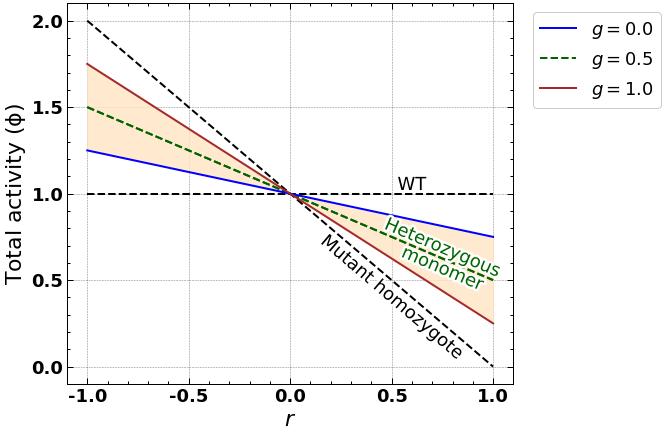

In [13]:
fig, ax = plt.subplots(figsize=(8,7))

# r and g values
r_vals = np.linspace(-1,1,201)
g_vals = np.array([0.0,0.5,1.0])

# duplicating WT activity values for plotting
act_m_WT_vals = act_m_WT*np.ones_like(r_vals)

# xticks and label
xticks_fig2 = np.linspace(-1,1,5)
xlabel_fig2 = "$r$"
yticks_fig2 = np.linspace(0,2,5)
ylabel_fig2 = r"Total activity ($\mathrm{\phi}$)"

fig1_data = [(act_m_WT_vals, "black", "WT"), (act_m_hetero[0], "darkgreen", "Heterozygous"), 
             (act_m_hetero[0], "darkgreen", "monomer"), (act_m_homo_mut, "black", "Mutant homozygote")]

for (dat, color, label) in fig1_data:
    ax.plot(r_vals, dat, color=color, label=label, ls="--") # plotting results for WT, Het mono and Mut homo systems
        
colors=["blue", _, "brown"]
for j in [0,2]:
    ax.plot(r_vals, act_d_hetero[j+1], color=colors[j], label=f"$g$={g_vals[j]}") # plotting results for heterozygous dimer and dimerization effect

# inline labels for monomer systems
lines = ax.get_lines()
labelLines(lines[0:4], xvals=[0.6,0.75,0.75,0.5], yoffsets=[0.05,0.06,-0.06,-0.1], fontsize=18)

ax.fill_between(r_vals, act_d_hetero[1], act_d_hetero[-2], alpha=0.8, color="bisque")  # shaded region for activity landscape for het dimer system
    
# x and y ticks and labels
ax.set_xticks(xticks_fig2, labels=np.round(xticks_fig2, 1), fontsize=18, fontweight="bold")
ax.set_yticks(yticks_fig2, labels=np.round(yticks_fig2, 2), fontsize=18, fontweight="bold")
ax.set_xlabel(xlabel_fig2, fontsize=22)
ax.set_ylabel(ylabel_fig2, fontsize=22)
    
plt.legend(handles=[lines[4], lines[1], lines[5]], labels=["$g=0.0$", "$g=0.5$", "$g=1.0$"], bbox_to_anchor=[0,0,1.35,1], fontsize=18)
plt.savefig("../Figures/Main_figures/Figure2.pdf", dpi=800)
plt.show()


### **Figure 3**

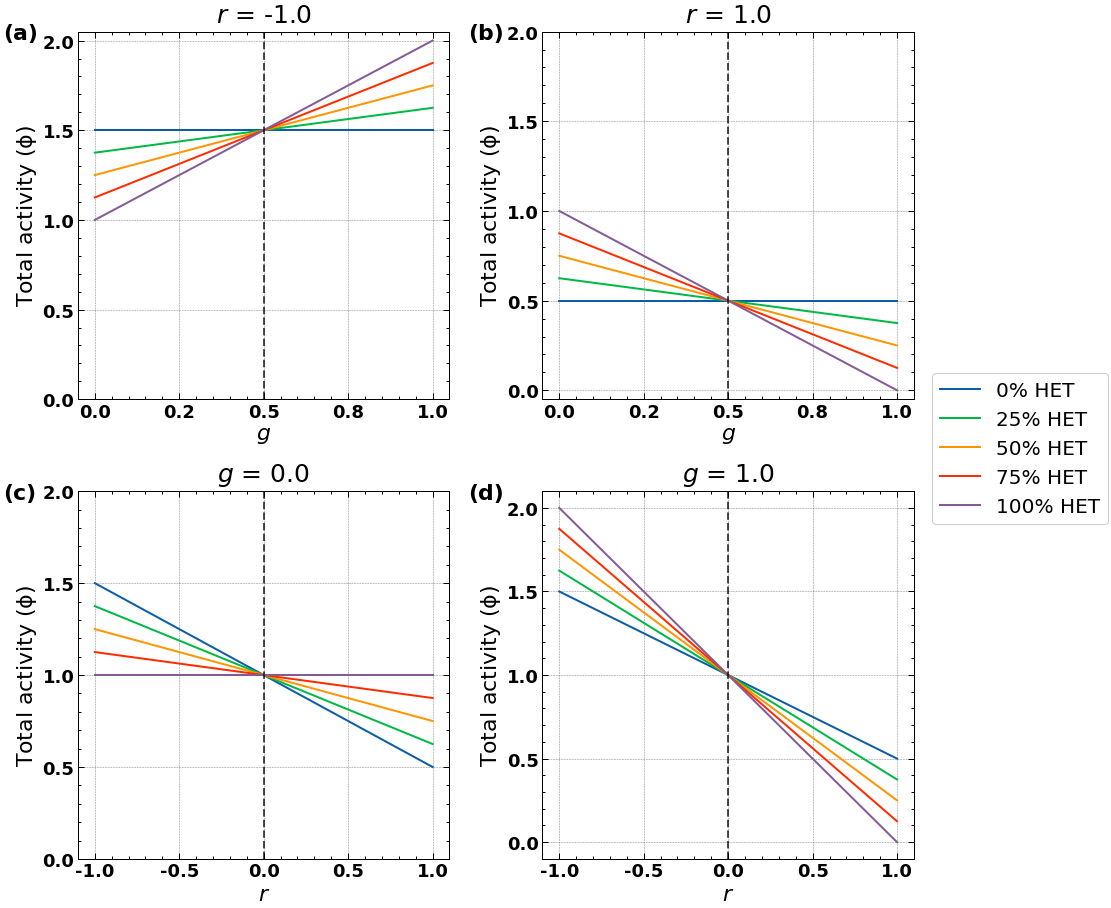

In [14]:
fig = plt.figure(figsize=(16,13.5))
gs = GridSpec(2, 2, figure=fig, height_ratios=[1,1], width_ratios=[1,1])
axs = [[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(2)]

panelnumbers = [["a","b"],["c","d"]]

# heterodimer percentage
percent_Het = ["0%","25%","50%","75%","100%"]

# fixed r and g values
r_vals_fix = [-1.0, 1.0]
g_vals_fix = [0.0, 1.0]

# sweep r and g values
r_vals_sweep = r_vals
g_vals_sweep = np.linspace(0,1,201)

# x and y ticks
xticks_fig3ab = np.linspace(0, 1, 5)
xticks_fig3cd = np.linspace(-1, 1, 5)
yticks_fig3 = np.linspace(0, 2, 5)

# ylabel
ylabel_fig3 = "Total activity ($\mathrm{\phi}$)"

# plotting data
fig3_data = [
    (g_vals_sweep, activity_cr, 0.5, "$g$", xticks_fig3ab, f"$r$ = ", r_vals_fix),
    (r_vals_sweep, activity_cg, 0.0, "$r$", xticks_fig3cd, f"$g$ = ", g_vals_fix)
]

for i, (xvals, data, vlinex, xlabel, xticks, title, fixed_param) in enumerate(fig3_data):
    for j in range(2):
        ax = axs[i][j]
        for k, p in enumerate(percent_Het):
            ax.plot(xvals, data[j][k], label=f"{p} HET")
        
        ax.axvline(vlinex, linestyle="--", linewidth=2, color="black", alpha=0.7) # vertical line at g=0.5 and r-0.0
        
        # x and y ticks and labels
        ax.set_xticks(xticks, labels=np.round(xticks,1), fontsize=18, fontweight="bold")
        ax.set_yticks(yticks_fig3, labels=np.round(yticks_fig3,1), fontsize=18, fontweight="bold")
        ax.set_xlabel(xlabel, fontsize=22)
        ax.set_ylabel(ylabel_fig3, fontsize=22)
        
        # panel title and annotation
        ax.set_title(title + f"{fixed_param[j]}", fontsize=25, pad=10)
        ax.annotate(f"({panelnumbers[i][j]})", xy=(-0.20, 0.98),
                    xycoords="axes fraction", fontsize=22, fontweight="bold")
        
plt.legend(bbox_to_anchor=(1.55, 1.35), fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.savefig("../Figures/Main_figures/Figure3.pdf", dpi=800)
plt.show()


### **Figure 4**

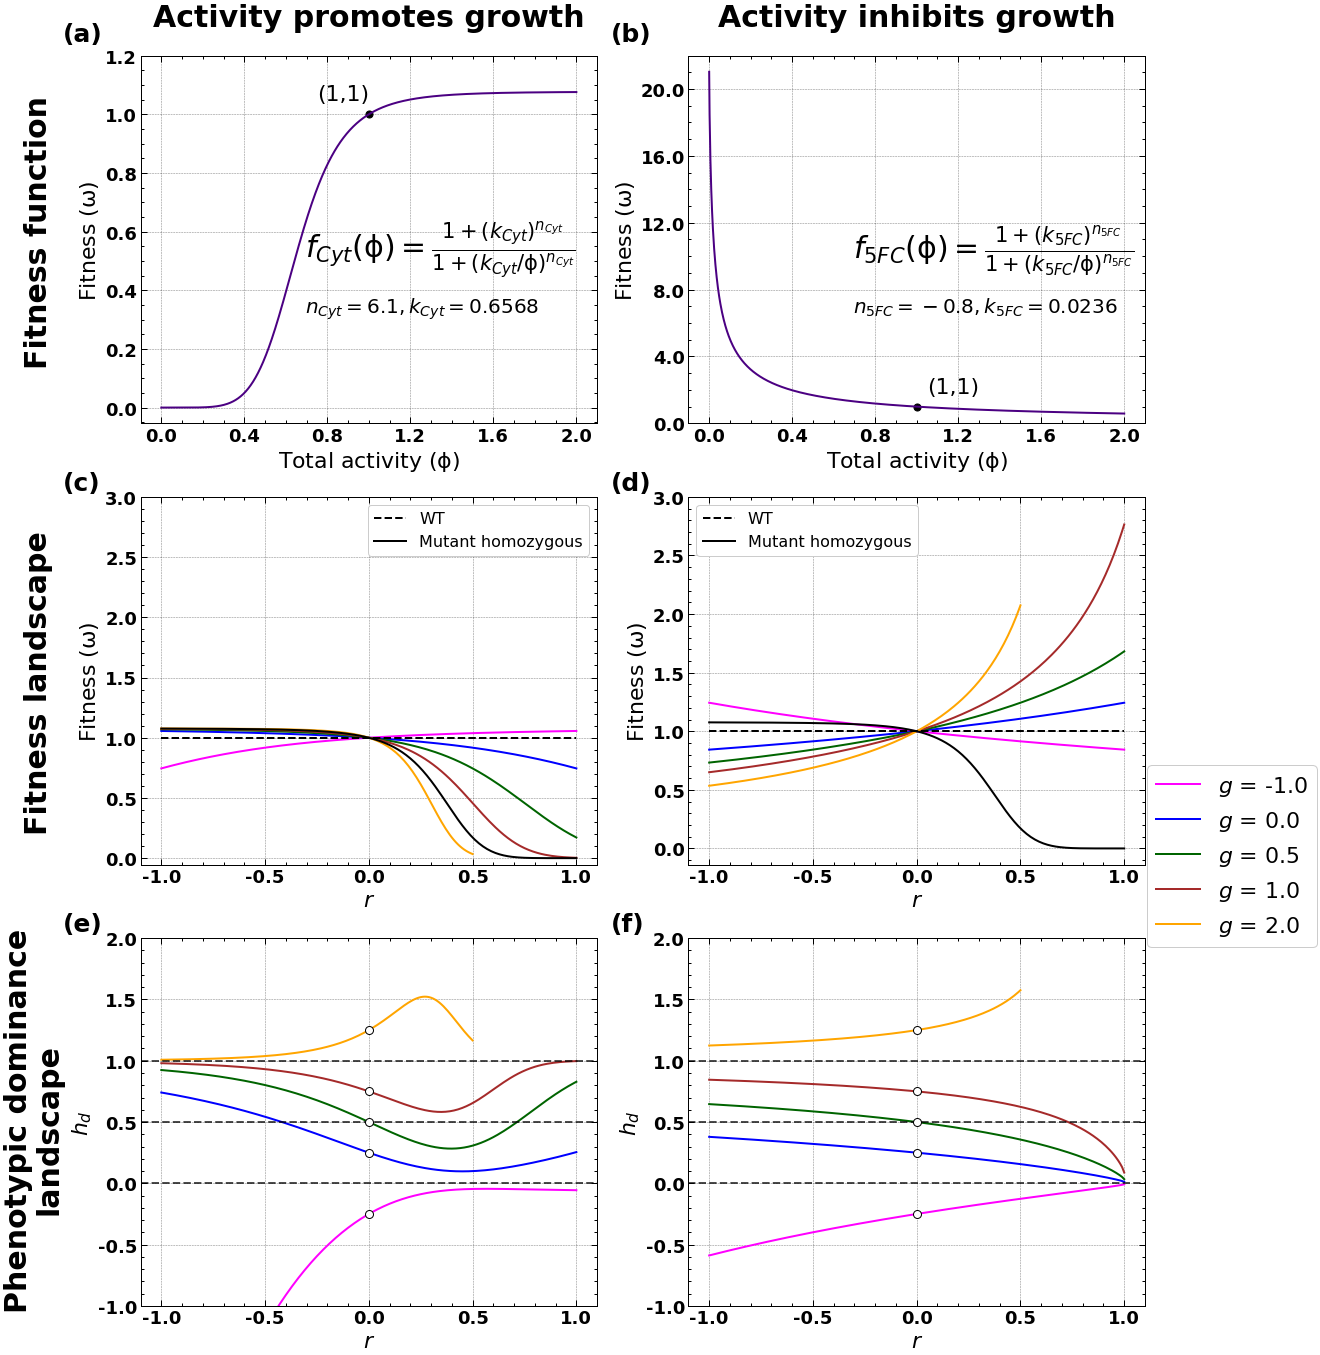

In [15]:
fig = plt.figure(figsize=(18,23))
gs = GridSpec(3,2,figure=fig,height_ratios=[1,1,1],width_ratios=[1,1])
axs = {f"{i}{j}" : fig.add_subplot(gs[i,j]) for i in range(3) for j in range(2)}

"""panels (a), (b) : fitness functions"""

# activity and fitness values
phi_range = np.linspace(0,2,1000)
fit1 = [fitness_1(phi) for phi in phi_range]
fit2 = [fitness_2(phi) for phi in phi_range]

# x and y ticks
xticks_fig4ab = np.linspace(0,2,6)
yticks_fig4a = np.linspace(0,1.2,7)
yticks_fig4b = np.linspace(0,20,6)

# plotting data
fig4ab_data = [
    ("00", fit1, yticks_fig4a, fr"$n_{{Cyt}} = {n1}, k_{{Cyt}} = {np.round(k1, 4)}$", 
     r"$f_{Cyt}\mathrm{(\phi)} = \frac{1 + (k_{Cyt})^{n_{Cyt}}}{1 + (k_{Cyt}/\mathrm{\phi})^{n_{Cyt}}}$", "Activity promotes growth", "(a)"),
    ("01", fit2, yticks_fig4b, fr"$n_{{5FC}} = {n2}, k_{{5FC}} = {np.round(k2, 4)}$", 
     r"$f_{5FC}\mathrm{(\phi)} = \frac{1 + (k_{5FC})^{n_{5FC}}}{1 + (k_{5FC}/\mathrm{\phi})^{n_{5FC}}}$", "Activity inhibits growth", "(b)")
]

for i, data, yticks, nk, funcname, title, panel in fig4ab_data:
    ax = axs[i]
    ax.plot(phi_range, data, color="indigo") # fitness function
    
    # function expression and parameter values
    ax.text(0.36, 0.45, funcname, fontsize=30, transform=ax.transAxes) 
    ax.text(0.36, 0.3, nk, fontsize=20, transform=ax.transAxes)
    
    # (1,1)
    ax.scatter(1, 1, s=50, color="black")
    if i[1] == "0":
        ax.text(0.75, 1.05, "(1,1)", fontsize=22)
    elif i[1] == "1":
        ax.text(1.05, 1.8, "(1,1)", fontsize=22)
        ax.set_ylim(0,22)
    
    # x and y ticks and labels
    ax.set_xticks(xticks_fig4ab, labels=np.round(xticks_fig4ab, 1), fontsize=18, fontweight="bold")
    ax.set_yticks(yticks, labels=np.round(yticks, 1), fontsize=18, fontweight="bold")
    ax.set_xlabel(r"Total activity ($\mathrm{\phi}$)", fontsize=22)
    ax.set_ylabel(r"Fitness ($\mathrm{\omega}$)", fontsize=22)
    
    # panel title and annotation
    ax.set_title(title, fontsize=30, fontweight="bold", pad=30)            
    ax.annotate(panel, xy=(-0.17,1.04), xycoords="axes fraction", fontsize=25, fontweight="bold")
    
"""panels (c), (d), (e), (f) : fitness landscapes, phenotypic dominance landscapes"""

colors = ["magenta", "blue", "darkgreen", "brown", "orange"]
g_vals_fig4 = np.array([-1.0,0.0,0.5,1.0,2.0])

fit1_WT_vals = fit1_WT*np.ones_like(r_vals)
fit2_WT_vals = fit2_WT*np.ones_like(r_vals)

# x and y ticks
xticks_fig4cdef = np.linspace(-1,1,5)
yticks_fig4cd = np.linspace(0,3,7)
yticks_fig4ef = np.linspace(-1,2,7)

fig4cdef_data = [("10", fit1_d_hetero, (fit1_WT_vals, fit1_homo_mut), yticks_fig4cd, r"Fitness ($\mathrm{\omega}$)", "(c)"), 
                 ("11", fit2_d_hetero, (fit1_WT_vals, fit1_homo_mut), yticks_fig4cd, r"Fitness ($\mathrm{\omega}$)", "(d)"), 
                 ("20", h1_d, _, yticks_fig4ef, r"$h_d$", "(e)"), 
                 ("21", h2_d, _, yticks_fig4ef, r"$h_d$", "(f)")]

for i, data, data1, yticks, ylabel, panel in fig4cdef_data:
    ax = axs[i]
    for j, g in enumerate(g_vals_fig4):
        ax.plot(r_vals, data[j], color=colors[j], label=f"$g$ = {g}")

    # plot WT and mutant homozygotes fitness
    if i[0] == "1":
        line1, = ax.plot(r_vals, data1[0], linestyle="--", linewidth=2, color="black", alpha=1.0, label="WT")
        line2, = ax.plot(r_vals, data1[1], linewidth=2, color="black", alpha=1.0, label="Mutant homozygous")
        ax.legend(handles=[line1, line2], labels=["WT", "Mutant homozygous"])
        
    # mark undefined regions in h_d plots
    if i[0] == "2":
        ax.set_ylim(-1.0,2.0)
        ax.axhline(0.0, linestyle="--", linewidth=2, color="black", alpha=0.7) # h_d=0.0
        ax.axhline(0.5, linestyle="--", linewidth=2, color="black", alpha=0.7) # h_d=0.5
        ax.axhline(1.0, linestyle="--", linewidth=2, color="black", alpha=0.7) # h_d=1.0
        nan_idx = 100
        r_nan = r_vals[nan_idx]
        for i in range(data.shape[0]):
            left = data[i, nan_idx-1]
            right = data[i, nan_idx+1]
            h_nan = (left + right) / 2
            ax.plot(r_nan, h_nan, marker="o", markersize=8, markerfacecolor="white", markeredgecolor="black")
    
    # x and y ticks and labels
    ax.set_xticks(xticks_fig4cdef, labels=np.round(xticks_fig4cdef, 1), fontsize=18, fontweight="bold")
    ax.set_yticks(yticks, labels=np.round(yticks, 1), fontsize=18, fontweight="bold")
    ax.set_xlabel("$r$", fontsize=22)
    ax.set_ylabel(ylabel, fontsize=22)
            
    # panel annotation
    ax.annotate(panel, xy=(-0.17, 1.02), xycoords="axes fraction", fontsize=25, fontweight="bold")
    
# row headers
plt.text(-4.3, 6.7, "Fitness function", fontsize=30, fontweight="bold", rotation=90)
plt.text(-4.3, 2.9, "Fitness landscape", fontsize=30, fontweight="bold", rotation=90)
plt.text(-4.4, -1.0, "Phenotypic dominance", fontsize=30, fontweight="bold", rotation=90) 
plt.text(-4.25, -0.2, "landscape", fontsize=30, fontweight="bold", rotation=90)

plt.legend(bbox_to_anchor=[1.4,1.5], fontsize=22)
plt.subplots_adjust(hspace=0.2)
plt.savefig("../Figures/Main_figures/Figure4.pdf", dpi=800)
plt.show()

## **Results (supplementary)**

In [16]:
### Supplementary Figures

# calling the helper function for Heterozygous dimer system for r values of (-1,1) and g values of (0,1)
Het_results_S13 = Heterozygous(r_vals=np.linspace(-1,1,201), g_vals=np.linspace(0,1,201), s1=s1, s2=s2)

# setting heterodimer equilibrium concentrations for heterospecificity
cAB_fraction_S2 = np.linspace(0,1,201)
cAB_vals_S2 = cAB_fraction_S2*0.5 # total conc = 0.5

# calling the helper function for Heterozygous dimer system with heterodimer conc. as cAB_vals_S2, fixed r ([-1.0, 1.0]) or g ([0.0, 1.0]) values
Het_spec_r_S2 = Heterospecificity(fixed_param="r", cAB_vals=cAB_vals_S2, fixed_vals=[-1.0,1.0], sweep_vals=np.linspace(0,1,201), s1=s1_1, s2=s2_1)
Het_spec_g_S2 = Heterospecificity(fixed_param="g", cAB_vals=cAB_vals_S2, fixed_vals=[0.0,1.0], sweep_vals=np.linspace(-1,1,201), s1=s1, s2=s2)

### Supplementary Video

# splitting the range of g-values into intervals, to simulate the animation pausing at important g values
important_g_vals = [-0.5, 0, 0.5, 1, 1.5]  # points where animation pauses
repeats = 33 # no. of repeats for each of the above points

g_vals_SV = np.linspace(-1, 2, 200)

for g in important_g_vals:
    g_vals_SV = np.insert(g_vals_SV, np.searchsorted(g_vals_SV, g), [g] * repeats)

g_vals_SV1 = np.concatenate((g_vals_SV, g_vals_SV[::-1], g_vals_SV, g_vals_SV[::-1]))

# calling the helper function for Heterozygous dimer system for r values of (-1,1) and g values = g_vals_SV1
Het_results_SV1 = Heterozygous(r_vals=np.linspace(-1,1,201), g_vals=g_vals_SV1, s1=s1, s2=s2)


In [17]:
# extracting and renaming the necessary results for plotting
act_m_hetero_S1 = Het_results_S13["mono"]["act"]
act_d_hetero_S1 = Het_results_S13["di"]["act"]
act_r_hetero_S1 = Het_results_S13["rel"]["act"]

activity_cr_S2 = [Het_spec_r_S2[i]["act"] for i in range(len(Het_spec_r_S2))]
activity_cg_S2 = [Het_spec_g_S2[i]["act"] for i in range(len(Het_spec_g_S2))]

fit1_d_hetero_S3 = Het_results_S13['di']['fit1']
fit2_d_hetero_S3 = Het_results_S13['di']['fit2']
h1_d_S3 = Het_results_S13['di']['h1']
h2_d_S3 = Het_results_S13['di']['h2']

act_d_hetero_SV1 = Het_results_SV1["di"]["act"]
act_d_hetero_SV1 = act_d_hetero_SV1.astype(object)
act_d_hetero_SV1[np.isnan(act_d_hetero_SV1.astype(float))] = None


## **Plotting figures (supplementary)**

In [18]:
# generating and storing colormaps in a list
starts = [0.0, 0.5, 1.0, 2.0]
cmaps = [sns.cubehelix_palette(start=s, rot=0, dark=0.0, light=0.8, reverse=True, as_cmap=True) for s in starts]


### **Figure S1**

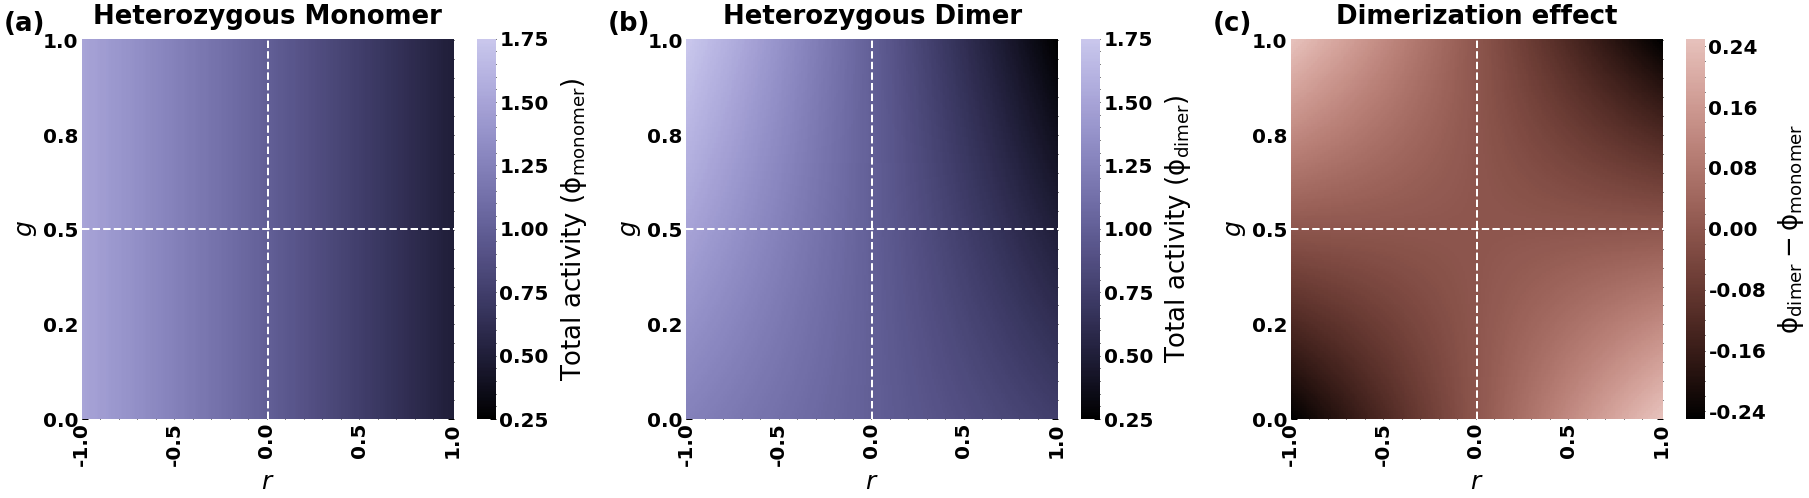

In [19]:
fig, axs = plt.subplots(1,3, figsize=(30,7))

# g values
g_vals_S = np.linspace(0,1,201)

# x and y ticks
xticks_S1 = np.arange(0, len(r_vals), 50)
xticklabels_S1 = np.round(r_vals[::50], 1)
yticks_S1 = np.arange(0, len(g_vals_S), 50)
yticklabels_S1 = np.round(g_vals_S[::50], 1)

# plotting data
figS1_data = [(act_m_hetero_S1, (0.25, 1.75), cmaps[0], r"Total activity ($\mathrm{\phi_{monomer}}$)", "Heterozygous Monomer", "(a)"), 
               (act_d_hetero_S1, (0.25, 1.75), cmaps[0], r"Total activity ($\mathrm{\phi_{dimer}}$)", "Heterozygous Dimer", "(b)"), 
               (act_r_hetero_S1, (-0.25, 0.25), cmaps[2], r"$\mathrm{\phi_{dimer} - \phi_{monomer}}$", "Dimerization effect", "(c)")]

for i, (dat, (vmin, vmax), cmap, cbarlabel, title, panelno) in enumerate(figS1_data):
    ax = axs[i]
    sns.heatmap(dat, ax=ax, vmin=vmin, vmax=vmax, cmap=cmap) # heatmap
    ax.invert_yaxis()
    
    # colorbar properties
    cbar = ax.collections[0].colorbar
    cbar.set_label(label=cbarlabel, fontsize=26, labelpad=10)
    cbar.ax.tick_params(labelsize=20)
    cbar.locator = MaxNLocator(nbins=7)
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    for label in cbar.ax.get_yticklabels():
        label.set_fontweight("bold")
        
    # lines for g=0.5, r=0.0
    ax.axhline(y=len(g_vals_S)/2, color="white", linestyle="--", linewidth=2, label="g=0.5")
    ax.axvline(x=len(r_vals)/2, color="white", linestyle="--", linewidth=2, label="r=0")
    
    # x and y ticks and labels
    ax.set_xticks(xticks_S1, xticklabels_S1, fontsize=20, fontweight="bold")
    ax.set_yticks(yticks_S1, yticklabels_S1, fontsize=20, fontweight="bold")
    ax.set_xlabel("$r$", fontsize=25)
    ax.set_ylabel("$g$", fontsize=25)
    
    # panel title and annotation
    ax.set_title(title, fontsize=26, fontweight="bold", pad=15)
    ax.annotate(panelno, xy=(-0.21, 1.02), xycoords="axes fraction", fontsize=26, fontweight="bold")
    
plt.subplots_adjust(wspace=0.3)
plt.savefig("../Figures/Supp_figures/FigureS1.pdf", dpi=800)
plt.show()


### **Figure S2**

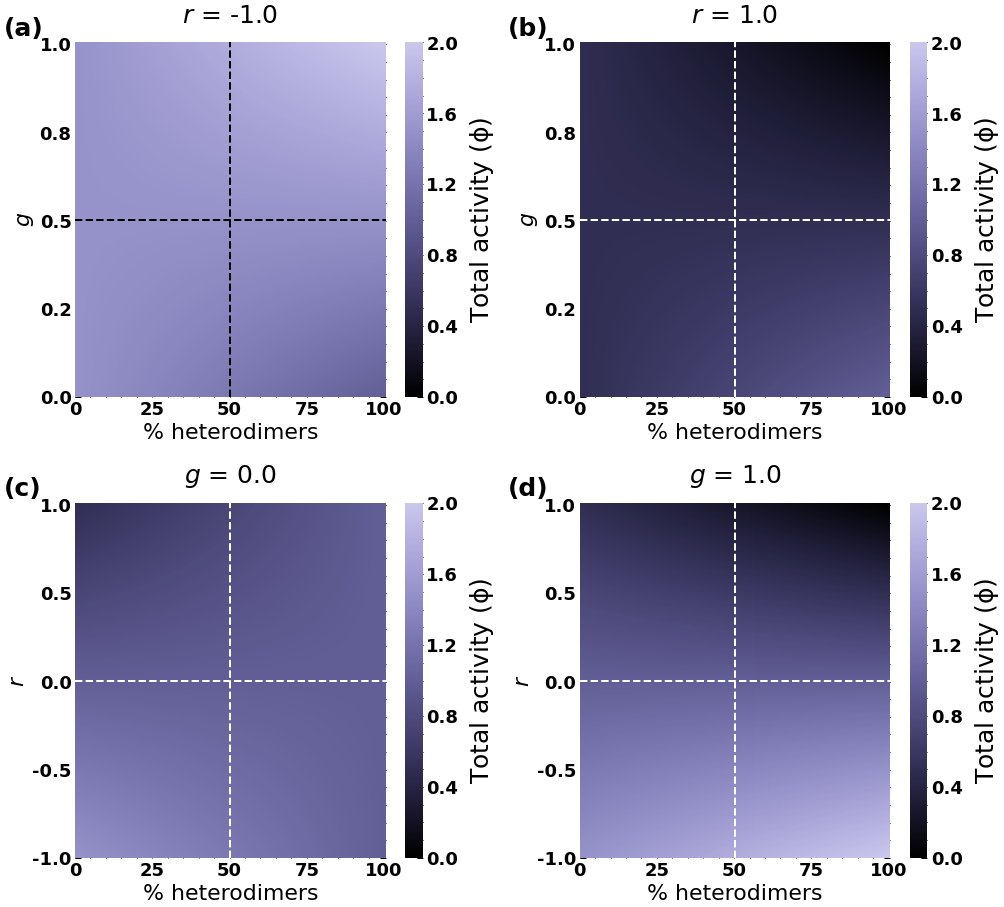

In [20]:
fig = plt.figure(figsize=(16,15))
gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 1], width_ratios=[1, 1])
axs = {f"{i}{j}": fig.add_subplot(gs[i, j]) for i in range(2) for j in range(2)}

# heterodimer percentage
cAB_percent_S2 = cAB_fraction_S2*100
cAB_percent_S2 = [int(cAB) for cAB in cAB_percent_S2]

# x and y ticks and ticklabels
xticks_S2 = np.arange(0, len(cAB_fraction_S2), 50)
xticklabels_S2 = cAB_percent_S2[::50]
yticks_S2ab = np.arange(0, len(g_vals_S), 50)
yticklabels_S2ab = np.round(g_vals_S[::50], 1)
yticks_S2cd = np.arange(0, len(r_vals), 50)
yticklabels_S2cd = np.round(r_vals[::50], 1)

# plotting data
figS2_data = [("00", activity_cr_S2[0], yticks_S2ab, yticklabels_S2ab, "$g$", "$r$ = -1.0", "(a)"), 
              ("01", activity_cr_S2[1], yticks_S2ab, yticklabels_S2ab, "$g$", "$r$ = 1.0", "(b)"), 
              ("10", activity_cg_S2[0], yticks_S2cd, yticklabels_S2cd, "$r$", "$g$ = 0.0", "(c)"), 
              ("11", activity_cg_S2[1], yticks_S2cd, yticklabels_S2cd, "$r$", "$g$ = 1.0", "(d)")]

for (i, data, yticks, yticklabels, ylabel, title, panelno) in figS2_data:
    ax = axs[i]
    sns.heatmap(data.T, ax=ax, cmap=cmaps[0], vmin=0.0, vmax=2.0) # heatmap
    ax.invert_yaxis()
    
    # colorbar properties
    cbar = ax.collections[0].colorbar
    cbar.set_label(label=r"Total activity ($\mathrm{\phi}$)", fontsize=25, loc="center", labelpad=10)
    cbar.ax.tick_params(labelsize=18)
    cbar.locator = MaxNLocator(nbins=6)
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    for label in cbar.ax.get_yticklabels():
        label.set_fontweight("bold")

    # lines for 50% heterodimers, g=0.5 or r=0.0    
    ax.axhline(y=len(g_vals_S)/2 if i[0]=="0" else len(r_vals)/2, 
               color="black" if i=="00" else "white", linestyle="--", linewidth=2, label="g=0.5 or r=0.0")
    ax.axvline(x=len(cAB_vals_S2)/2, color="black" if i=="00" else "white", linestyle="--", linewidth=2, label="50%Het")
    
    # x and y ticks and labels
    ax.set_xticks(xticks_S2, xticklabels_S2, fontsize=18, fontweight="bold", rotation=0)
    ax.set_yticks(yticks, yticklabels, fontsize=18, fontweight="bold")
    ax.set_xlabel("% heterodimers", fontsize=22)
    ax.set_ylabel(ylabel, fontsize=22)
    
    # panel title and annotation
    ax.set_title(title, fontsize=25, pad=20)
    ax.annotate(panelno, xy=(-0.23, 1.02), xycoords="axes fraction", fontsize=25, fontweight="bold")
    
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig("../Figures/Supp_figures/FigureS2.pdf", dpi=600)
plt.show()


### **Figure S3**

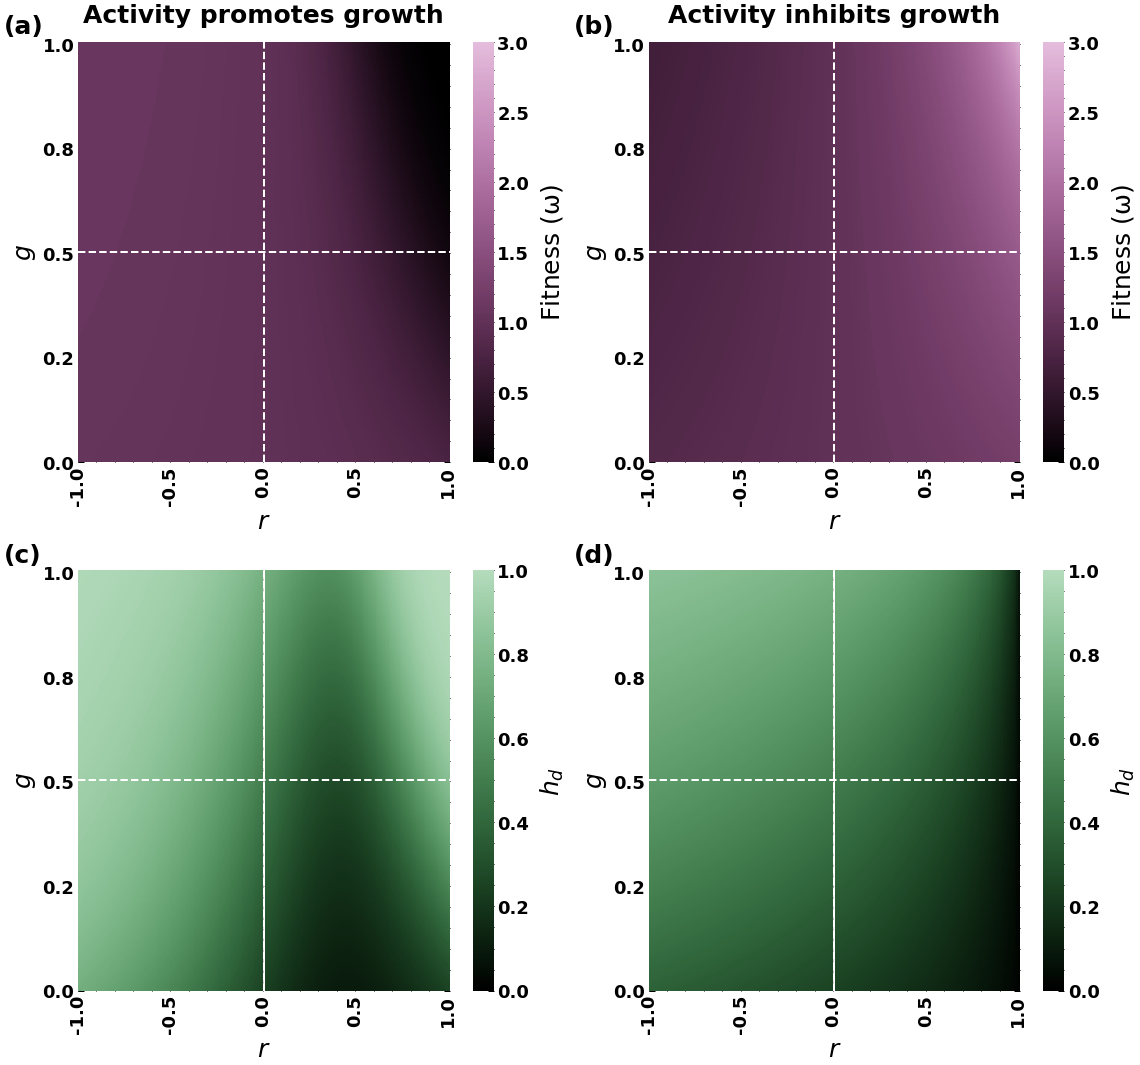

In [21]:
fig = plt.figure(figsize=(16,15))
gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 1], width_ratios=[1, 1])
axs = {f"{i}{j}": fig.add_subplot(gs[i, j]) for i in range(2) for j in range(2)}

# x and y ticks and ticklabels
xticks_S3 = np.arange(0, len(r_vals), 50)
xticklabels_S3 = np.round(r_vals[::50], 1)
yticks_S3 = np.arange(0, len(g_vals_S), 50)
yticklabels_S3 = np.round(g_vals_S[::50], 1)

# plotting data
figS3_data = [("00", fit1_d_hetero_S3, cmaps[1], (0.0, 3.0), r"Fitness ($\mathrm{\omega}$)", "Activity promotes growth", "(a)"), 
               ("01", fit2_d_hetero_S3, cmaps[1], (0.0, 3.0), r"Fitness ($\mathrm{\omega}$)", "Activity inhibits growth", "(b)"), 
               ("10", h1_d_S3, cmaps[3], (0.0, 1.0), r"$h_d$", _, "(c)"), 
               ("11", h2_d_S3, cmaps[3], (0.0, 1.0), r"$h_d$", _, "(d)")]

for (i, dat, cmap, (vmin, vmax), cbarlabel, title, panelno) in figS3_data:
    ax = axs[i]
    sns.heatmap(dat, ax=ax,cmap=cmap, vmin=vmin, vmax=vmax) # heatmap
    ax.invert_yaxis()
    
    # colorbar properties
    cbar = ax.collections[0].colorbar
    cbar.set_label(label=cbarlabel, fontsize=25, loc="center", labelpad=10)
    cbar.ax.tick_params(labelsize=18)
    cbar.locator = MaxNLocator(nbins=6)
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    for label in cbar.ax.get_yticklabels():
        label.set_fontweight("bold")
    
    # lines for g=0.5 and r=0.0
    ax.axhline(y=len(g_vals_S)/2, color="white", linestyle="--", linewidth=2, label="g=0.5")
    ax.axvline(x=len(r_vals)/2, color="white", linestyle="--", linewidth=2, label="r=0")
    
    # x and y ticks and labels
    ax.set_xticks(xticks_S3, xticklabels_S3, fontsize=18, fontweight="bold")
    ax.set_yticks(yticks_S3, yticklabels_S3, fontsize=18, fontweight="bold")
    ax.set_xlabel("$r$", fontsize=25)
    ax.set_ylabel("$g$", fontsize=25)
    
    # panel title and annotation
    if i[0] == "0":
        ax.set_title(title, fontsize=25, fontweight="bold", pad=20)
    ax.annotate(panelno, xy=(-0.2, 1.02), xycoords="axes fraction", fontsize=25, fontweight="bold")
    
plt.tight_layout()
plt.savefig("../Figures/Supp_figures/FigureS3.pdf", dpi=300)
plt.show()


### Supplementary Video SV1

[]

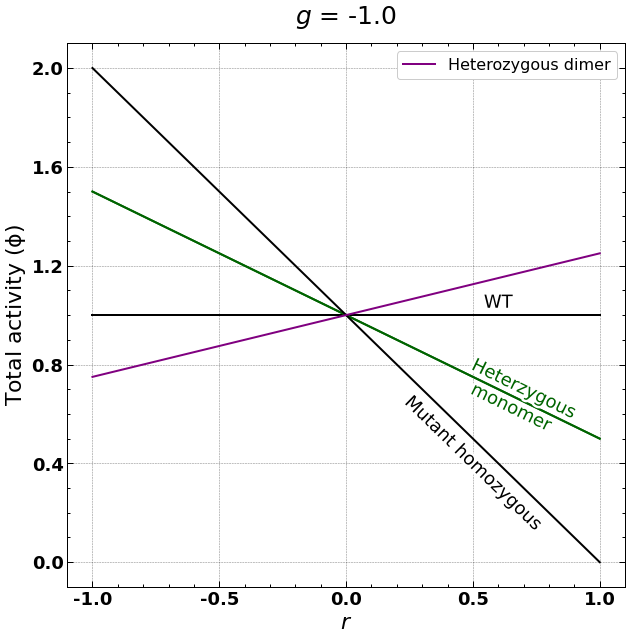

In [22]:
fig, ax = plt.subplots(figsize=(10,10))

# x and y ticks and ticklabels
xticks_SV1 = np.linspace(-1,1,5)
yticks_SV1 = np.linspace(0,2.4,7)

# plotting the three fixed fitness plots
ax.plot(r_vals, act_m_WT_vals, label="WT", c="black")
ax.plot(r_vals, act_m_hetero[0], label="Heterzygous", c="darkgreen")
ax.plot(r_vals, act_m_hetero[0], label="monomer", c="darkgreen")
ax.plot(r_vals, act_m_homo_mut, label="Mutant homozygous", c="black")

# in line labels for monomer systems
lines = ax.get_lines()
labelLines(lines, xvals=[0.6,0.7,0.65,0.5], yoffsets=[0.05,0.05,-0.05,-0.1], fontsize=18)

# plotting the animation for fitness of heterozygous dimer genotype
N = len(g_vals_SV1)
def update(frame, ax, line, xdata, ydata, tdata, anim=False):
    if line is None:
        line, = ax.plot(xdata, ydata[frame], label="Heterozygous dimer", c="purple")
    line.set_data(xdata, ydata[frame])
    ax.set_title(f"$g$ = {round(tdata[frame],1)}", fontsize=25, pad=20)
    return line,
line, = update(0, ax, None, r_vals, act_d_hetero_SV1, g_vals_SV1, True)

# x and y ticks and labels
ax.set_xlabel("$r$", fontsize=22)
ax.set_ylabel("Total activity ($\mathrm{\phi}$)", fontsize=22)
ax.set_xticks(xticks_SV1, labels=np.round(xticks_SV1, 1), fontsize=18, fontweight="bold")
ax.set_yticks(yticks_SV1, labels=np.round(yticks_SV1, 1), fontsize=18, fontweight="bold")

ax.legend([line], [line.get_label()])

# update animation
update_anim = functools.partial(update, ax=ax, line=line, xdata=r_vals, ydata=act_d_hetero_SV1, 
                                tdata=g_vals_SV1, anim=True)
ani = animation.FuncAnimation(fig, update_anim, N, interval=15, blit=False)

# save animation
writer = FFMpegWriter(fps=30, codec="libx264")
ani.save("../Figures/Supp_figures/VideoS1.mp4", writer=writer, dpi=80)

plt.plot()